Assignment-3 Timeseries 
Sairithik singamalla
811286106

In [4]:
import os
import zipfile
import urllib.request

url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
filename = "jena_climate_2009_2016.csv.zip"
unzipped_filename = "jena_climate_2009_2016.csv"

if not os.path.exists(filename):
    # File doesn't exist, download it
    urllib.request.urlretrieve(url, filename) # Indented this line to be inside the if block

if os.path.exists(filename):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()
    print(f"{filename} unzipped successfully.")
else:
    print("File not found and could not be downloaded.")

jena_climate_2009_2016.csv.zip unzipped successfully.


Performing data analysis on the Jena weather dataset.

In [5]:
file_path = os.path.join("jena_climate_2009_2016.csv")
with open(file_path) as file:
    file_data = file.read()
    file_lines = file_data.split("\n")
    headers = file_lines[0].split(",")
    file_lines = file_lines[1:]
    print(headers)
    print(len(file_lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Interpreting and processing the data.

In [6]:
import numpy as np
temperature_data = np.zeros((len(file_lines),))
climate_data = np.zeros((len(file_lines), len(headers) - 1))
for line_index, line_entry in enumerate(file_lines):
    line_measurements = [float(value) for value in line_entry.split(",")[1:]]
    temperature_data[line_index] = line_measurements[1]
    climate_data[line_index, :] = line_measurements[:]

Creating a temperature time series plot.

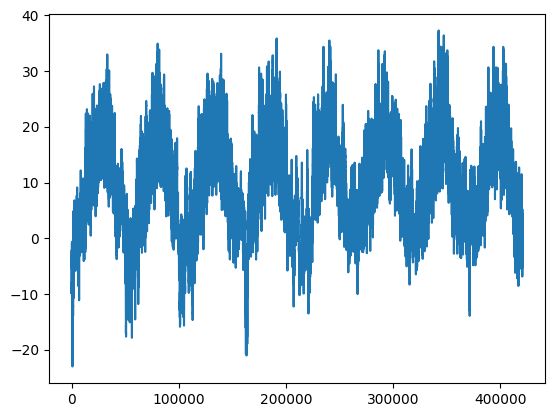

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature_data)), temperature_data)

Visualizing the temperature time series for the first 10 days.

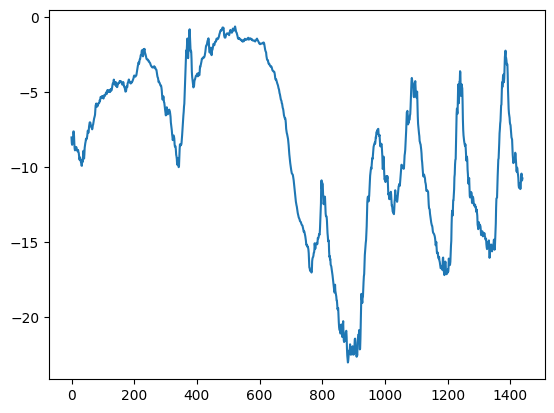

In [8]:
plt.plot(range(1440), temperature_data[:1440])

Calculating the number of samples for each data split.

In [9]:
num_training_samples = int(0.5 * len(climate_data))
num_validation_samples = int(0.25 * len(climate_data))
num_testing_samples = len(climate_data) - num_training_samples - num_validation_samples
print("num_training_samples:", num_training_samples)
print("num_validation_samples:", num_validation_samples)
print("num_testing_samples:", num_testing_samples)


num_training_samples: 210225
num_validation_samples: 105112
num_testing_samples: 105114


Data preparation and normalization.

In [10]:
training_mean = climate_data[:num_training_samples].mean(axis=0)
climate_data -= training_mean
training_std = climate_data[:num_training_samples].std(axis=0)
climate_data /= training_std

In [11]:
import numpy as np
from tensorflow import keras

sequence_array = np.arange(10)
example_dataset = keras.utils.timeseries_dataset_from_array(
    data=sequence_array[:-3],
    targets=sequence_array[3:],
    sequence_length=3,
    batch_size=2,
)

for input_batch, target_batch in example_dataset:
    for i in range(input_batch.shape[0]):
        print([int(x) for x in input_batch[i]], int(target_batch[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Creating datasets for training, validation, and testing.

In [12]:
sampling_interval = 6
sequence_len = 120
time_delay = sampling_interval * (sequence_len + 24 - 1)
batch_size_value = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    climate_data[:-time_delay],
    targets=temperature_data[time_delay:],
    sampling_rate=sampling_interval,
    sequence_length=sequence_len,
    shuffle=True,
    batch_size=batch_size_value,
    start_index=0,
    end_index=num_training_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    climate_data[:-time_delay],
    targets=temperature_data[time_delay:],
    sampling_rate=sampling_interval,
    sequence_length=sequence_len,
    shuffle=True,
    batch_size=batch_size_value,
    start_index=num_training_samples,
    end_index=num_training_samples + num_validation_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    climate_data[:-time_delay],
    targets=temperature_data[time_delay:],
    sampling_rate=sampling_interval,
    sequence_length=sequence_len,
    shuffle=True,
    batch_size=batch_size_value,
    start_index=num_training_samples + num_validation_samples
)

Examining the output of a dataset.

In [13]:
for sample_batch, target_batch in train_dataset:
    print("samples shape:", sample_batch.shape)
    print("targets shape:", target_batch.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


A simple, intuitive baseline not based on machine learning.

Calculating the mean absolute error (MAE) for the common-sense baseline.

In [14]:
def evaluate_naive_method(dataset):
    total_absolute_error = 0.0
    samples_count = 0

    for sample_batch, target_batch in dataset:
        predictions = sample_batch[:, -1, 1] * training_std[1] + training_mean[1]
        total_absolute_error += np.sum(np.abs(predictions - target_batch))
        samples_count += sample_batch.shape[0]

    return total_absolute_error / samples_count

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Let's experiment with a simple machine learning model.

Training and assessing a fully connected model.

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_len, climate_data.shape[-1]))
x = layers.GlobalAveragePooling1D()(inputs)  # Using pooling instead of flatten
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - loss: 78.8852 - mae: 7.0290 - val_loss: 22.2729 - val_mae: 3.7314
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 22.7523 - mae: 3.8253 - val_loss: 20.6778 - val_mae: 3.6026
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 21.9717 - mae: 3.7501 - val_loss: 20.7566 - val_mae: 3.6062
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 21.8216 - mae: 3.7320 - val_loss: 20.6592 - val_mae: 3.5998
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 21.6785 - mae: 3.7174 - val_loss: 20.7725 - val_mae: 3.6039
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 21.5973 - mae: 3.7103 - val_loss: 20.6109 - val_mae: 3.5925
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 21.5354 - mae: 3.7050 - val_loss: 20.6035 - val_mae: 3.5908
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 21.4588 - mae: 3.6980 - val_loss: 20.4673 - val_mae: 3.5761
Epoch 9/10
819/819 ━━━━━

Visualizing the results.

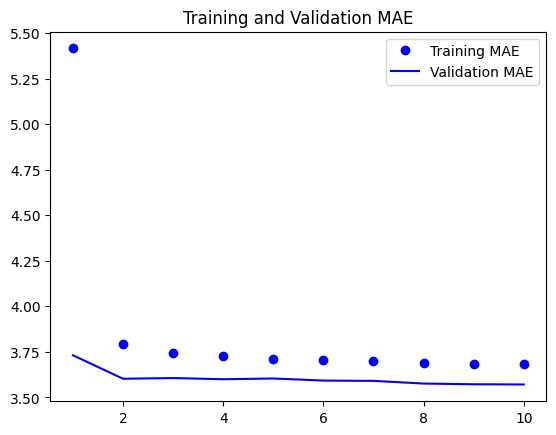

In [16]:
import matplotlib.pyplot as plt

training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epochs = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epochs, training_mae, "bo", label="Training MAE")
plt.plot(epochs, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

Let's experiment with a 1D convolutional model.

In [17]:
inputs = keras.Input(shape=(sequence_len, climate_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - loss: 38.3132 - mae: 4.6701 - val_loss: 15.1307 - val_mae: 3.0647
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 15.7856 - mae: 3.1627 - val_loss: 14.2461 - val_mae: 2.9549
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 14.0888 - mae: 2.9877 - val_loss: 14.1591 - val_mae: 2.9465
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 13.2037 - mae: 2.8895 - val_loss: 13.4295 - val_mae: 2.8805
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 12.5990 - mae: 2.8189 - val_loss: 18.0348 - val_mae: 3.4007
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 12.1695 - mae: 2.7683 - val_loss: 14.8622 - val_mae: 3.0235
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 11.7762 - mae: 2.7214 - val_loss: 14.8841 - val_mae: 3.0179
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 11.4102 - mae: 2.6785 - val_loss: 16.9586 - val_mae: 3.2329
Epoch 9/10
819/819 ━━━━━


Visualizing the results.

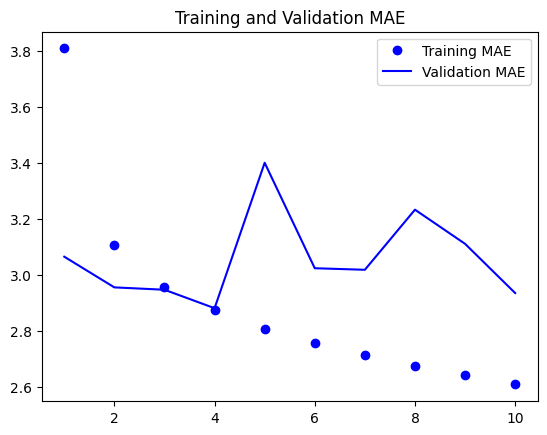

In [18]:
import matplotlib.pyplot as plt

training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epochs = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epochs, training_mae, "bo", label="Training MAE")
plt.plot(epochs, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


An initial recurrent baseline.

A basic LSTM model with a Dense layer of 16 units.

In [19]:
inputs = keras.Input(shape=(sequence_len, climate_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 96ms/step - loss: 64.3121 - mae: 6.0732 - val_loss: 11.6694 - val_mae: 2.6210
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 76s 92ms/step - loss: 11.2163 - mae: 2.5951 - val_loss: 9.8619 - val_mae: 2.4401
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 73s 89ms/step - loss: 9.6299 - mae: 2.4208 - val_loss: 9.7450 - val_mae: 2.4357
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 70s 86ms/step - loss: 9.2241 - mae: 2.3680 - val_loss: 9.9691 - val_mae: 2.4648
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 70s 86ms/step - loss: 8.8406 - mae: 2.3187 - val_loss: 10.2519 - val_mae: 2.4821
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 71s 86ms/step - loss: 8.4912 - mae: 2.2706 - val_loss: 10.0507 - val_mae: 2.4600
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 71s 87ms/step - loss: 8.2392 - mae: 2.2372 - val_loss: 9.8641 - val_mae: 2.4430
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 90ms/step - loss: 8.0633 - mae: 2.2157 - val_loss: 10.0356 - val_mae: 2.4611
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━

Displaying the results in a plot.

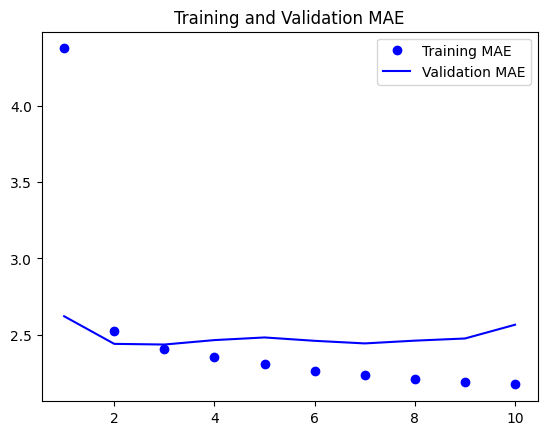

In [20]:
import matplotlib.pyplot as plt

training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epochs = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epochs, training_mae, "bo", label="Training MAE")
plt.plot(epochs, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

A basic LSTM model with a Dense layer of 32 units.

In [22]:
inputs = keras.Input(shape=(sequence_len, climate_data.shape[-1]))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 160s 191ms/step - loss: 44.7338 - mae: 4.8296 - val_loss: 9.7403 - val_mae: 2.4260
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 174ms/step - loss: 9.6321 - mae: 2.4226 - val_loss: 9.6010 - val_mae: 2.4094
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 171ms/step - loss: 8.5727 - mae: 2.2853 - val_loss: 10.1312 - val_mae: 2.4793
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - loss: 7.7830 - mae: 2.1803 - val_loss: 9.8544 - val_mae: 2.4585
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 174ms/step - loss: 7.2844 - mae: 2.1044 - val_loss: 9.6445 - val_mae: 2.4326
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 174ms/step - loss: 6.9226 - mae: 2.0506 - val_loss: 10.5693 - val_mae: 2.5415
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 174ms/step - loss: 6.5304 - mae: 1.9892 - val_loss: 10.4434 - val_mae: 2.5351
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 175ms/step - loss: 6.2607 - mae: 1.9476 - val_loss: 10.6634 - val_mae: 2.5556
Epoch 9/10
819/819 

Visualizing the results.

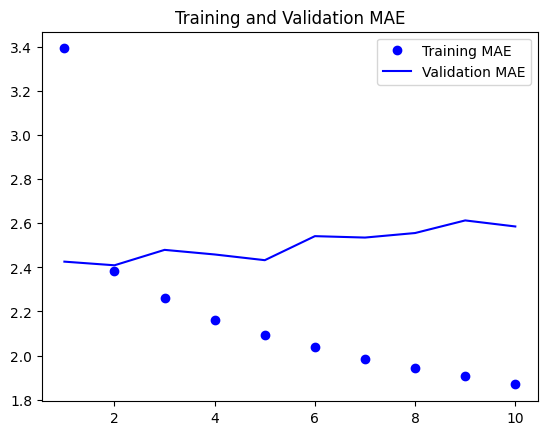

In [23]:
import matplotlib.pyplot as plt

training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epochs = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epochs, training_mae, "bo", label="Training MAE")
plt.plot(epochs, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


A straightforward LSTM model with a Dense layer of 64 units.

In [24]:
inputs = keras.Input(shape=(sequence_len, climate_data.shape[-1]))
x = layers.LSTM(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 253s 304ms/step - loss: 26.9629 - mae: 3.6999 - val_loss: 9.6134 - val_mae: 2.4188
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 240s 293ms/step - loss: 8.3782 - mae: 2.2632 - val_loss: 9.7375 - val_mae: 2.4404
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 166s 203ms/step - loss: 6.5759 - mae: 1.9951 - val_loss: 11.5060 - val_mae: 2.6534
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 173s 211ms/step - loss: 5.3071 - mae: 1.7819 - val_loss: 11.9054 - val_mae: 2.7114
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 172s 209ms/step - loss: 4.3999 - mae: 1.6196 - val_loss: 12.0437 - val_mae: 2.7084
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 160s 196ms/step - loss: 3.7766 - mae: 1.4965 - val_loss: 12.7335 - val_mae: 2.7973
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 181s 221ms/step - loss: 3.3266 - mae: 1.4045 - val_loss: 13.6914 - val_mae: 2.8980
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 173s 212ms/step - loss: 2.9804 - mae: 1.3268 - val_loss: 13.4930 - val_mae: 2.8675
Epoch 9/10
819/81

Displaying the results in a plot.

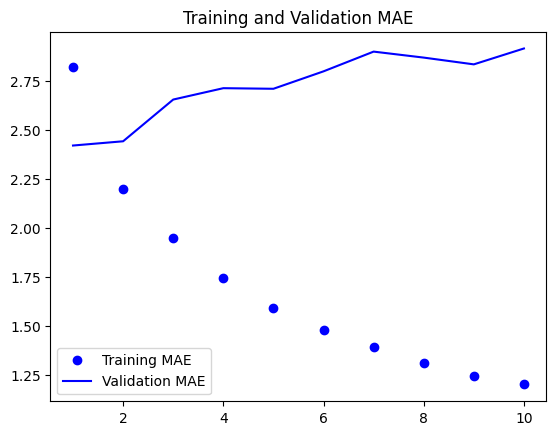

In [25]:
import matplotlib.pyplot as plt

training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epochs = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epochs, training_mae, "bo", label="Training MAE")
plt.plot(epochs, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


Grasping the concept of recurrent neural networks.

Numpy-based implementation of a simple RNN.

In [26]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

input_sequence = np.random.random((timesteps, input_features))
previous_state = np.zeros((output_features,))
weight_input = np.random.random((output_features, input_features))
weight_recurrent = np.random.random((output_features, output_features))
bias = np.random.random((output_features,))

successive_outputs = []

for current_input in input_sequence:
    output_t = np.tanh(np.dot(weight_input, current_input) + np.dot(weight_recurrent, previous_state) + bias)
    successive_outputs.append(output_t)
    previous_state = output_t

final_output_sequence = np.stack(successive_outputs, axis=0)

A recurrent Layer in Keras

An RNN layer capable of processing sequences of any length.

In [27]:
num_features = 14
input_layer = keras.Input(shape=(None, num_features))
output_layer = layers.SimpleRNN(16)(input_layer)

An RNN layer that outputs only its final step.

In [28]:
num_features = 14
sequence_length = 120
input_layer = keras.Input(shape=(sequence_length, num_features))
output_layer = layers.SimpleRNN(16, return_sequences=False)(input_layer)
print(output_layer.shape)


(None, 16)


An RNN layer that returns the entire output sequence.

In [29]:
num_features = 14
sequence_length = 120
input_layer = keras.Input(shape=(sequence_length, num_features))
output_layer = layers.SimpleRNN(16, return_sequences=True)(input_layer)
print(output_layer.shape)

(None, 120, 16)


Stacking multiple RNN layers.

In [30]:
input_layer = keras.Input(shape=(sequence_length, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(input_layer)
x = layers.SimpleRNN(16, return_sequences=True)(x)
output_layer = layers.SimpleRNN(16)(x)


Advanced applications of recurrent neural networks

Applying recurrent dropout to prevent overfitting

Training and evaluating a hybrid model combining 1D ConvNet and dropout-regularized LSTM

In [31]:
input_layer = keras.Input(shape=(sequence_length, num_features))
x = layers.Conv1D(32, 5, activation="relu", padding="same")(input_layer)
x = layers.MaxPooling1D(2)(x)
x = layers.LSTM(64, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1)(x)
model = keras.Model(input_layer, output_layer)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 103s 123ms/step - loss: 26.7047 - mae: 3.7813 - val_loss: 8.9814 - val_mae: 2.3283
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 106s 129ms/step - loss: 11.9619 - mae: 2.6962 - val_loss: 8.8859 - val_mae: 2.3117
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 120s 146ms/step - loss: 11.0236 - mae: 2.5850 - val_loss: 9.1293 - val_mae: 2.3390
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 103s 125ms/step - loss: 10.3856 - mae: 2.5066 - val_loss: 9.1559 - val_mae: 2.3328
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 94s 114ms/step - loss: 9.6665 - mae: 2.4172 - val_loss: 9.2379 - val_mae: 2.3601
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 94s 115ms/step - loss: 9.1563 - mae: 2.3488 - val_loss: 9.4586 - val_mae: 2.3834
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 104s 127ms/step - loss: 8.7432 - mae: 2.2929 - val_loss: 10.5832 - val_mae: 2.5326
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 94s 115ms/step - loss: 8.3774 - mae: 2.2433 - val_loss: 9.5681 - val_mae: 2.3975
Epoch 9/10
819/819 ━━━

Plotting results

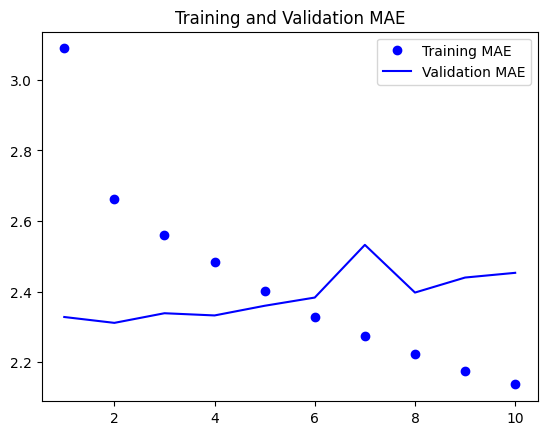

In [32]:
training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epoch_numbers = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epoch_numbers, training_mae, "bo", label="Training MAE")
plt.plot(epoch_numbers, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

In [33]:
input_shape = (sequence_length, num_features)
inputs = keras.Input(shape=input_shape)
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)


Stacking multiple recurrent layers.

Training and assessing a stacked LSTM model with dropout regularization.

In [35]:
input_shape = (sequence_length, num_features)
inputs = keras.Input(shape=input_shape)
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 180s 215ms/step - loss: 44.8422 - mae: 4.9559 - val_loss: 9.6164 - val_mae: 2.4082
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 190s 232ms/step - loss: 14.7879 - mae: 2.9899 - val_loss: 9.0828 - val_mae: 2.3385
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 189s 230ms/step - loss: 13.7297 - mae: 2.8766 - val_loss: 8.8392 - val_mae: 2.2948
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 199s 242ms/step - loss: 12.9960 - mae: 2.7942 - val_loss: 8.8218 - val_mae: 2.2879
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 213s 260ms/step - loss: 12.4113 - mae: 2.7339 - val_loss: 8.7859 - val_mae: 2.2836
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 209s 255ms/step - loss: 11.8416 - mae: 2.6652 - val_loss: 8.8878 - val_mae: 2.2997
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 210s 256ms/step - loss: 11.3924 - mae: 2.6122 - val_loss: 9.0157 - val_mae: 2.3169
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 213s 261ms/step - loss: 10.9847 - mae: 2.5623 - val_loss: 9.3322 - val_mae: 2.3580
Epoch 9/10
819/8

Plotting results

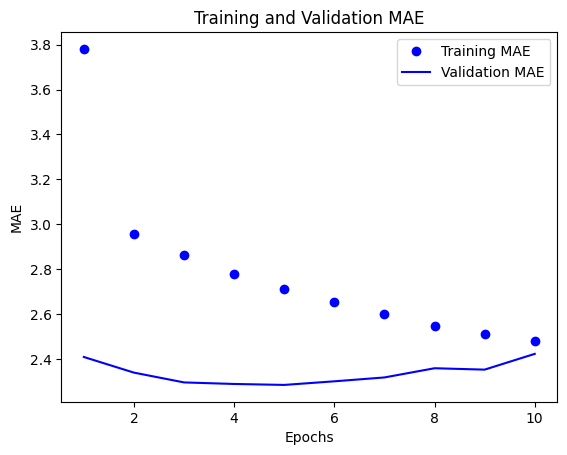

In [36]:
training_mae = history.history["mae"]
validation_mae = history.history["val_mae"]
epochs = range(1, len(training_mae) + 1)

plt.figure()
plt.plot(epochs, training_mae, "bo", label="Training MAE")
plt.plot(epochs, validation_mae, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Utilizing bidirectional RNNs.

Training and assessing a bidirectional LSTM.

In [37]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.Bidirectional(layers.LSTM(16, recurrent_dropout=0.25))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 98s 111ms/step - loss: 58.2858 - mae: 5.6297 - val_loss: 10.4823 - val_mae: 2.5152
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 89s 108ms/step - loss: 10.7006 - mae: 2.5550 - val_loss: 9.1675 - val_mae: 2.3562
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 91s 110ms/step - loss: 9.6918 - mae: 2.4243 - val_loss: 9.1307 - val_mae: 2.3382
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 91s 111ms/step - loss: 9.2660 - mae: 2.3702 - val_loss: 9.4577 - val_mae: 2.3750
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 93s 113ms/step - loss: 8.9297 - mae: 2.3278 - val_loss: 9.5112 - val_mae: 2.3758
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 97s 118ms/step - loss: 8.6446 - mae: 2.2898 - val_loss: 9.5536 - val_mae: 2.3830
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 99s 121ms/step - loss: 8.3666 - mae: 2.2567 - val_loss: 9.3181 - val_mae: 2.3552
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 113s 138ms/step - loss: 8.1292 - mae: 2.2291 - val_loss: 9.6660 - val_mae: 2.4038
Epoch 9/10
819/819 ━━━━━━━━━

plotting results

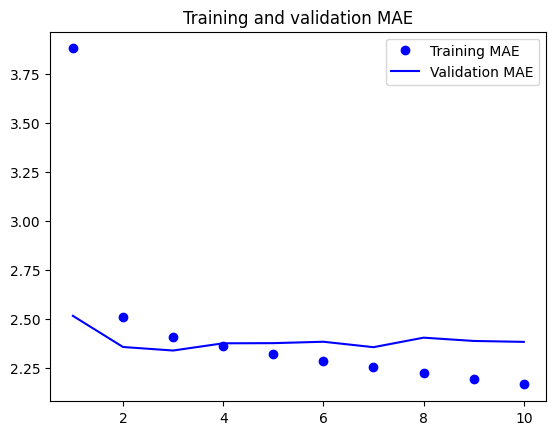

In [38]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()